In [46]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# File imported from Kaggle
df = pd.read_csv("SPX.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= '2015-01-01') & (df['Date'] <= '2020-12-31')]
df = df.sort_values('Date')
df['Return'] = df['Adj Close'].pct_change()
df_weekly = df.resample('W-MON', on='Date').last()  # W-MON: weekly, Monday as end of week
df_weekly['Return'] = df_weekly['Adj Close'].pct_change()
df_monthly = df.resample('M', on='Date').last()
df_monthly['Return'] = df_monthly['Adj Close'].pct_change()

df.head()
df_weekly.head()
df_monthly.head()



,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2015-01-31,2019.349976,2023.319946,1993.380005,1994.989990,1994.989990,4568650000,NaN
2015-02-28,2110.879883,2112.739990,2103.750000,2104.500000,2104.500000,3547380000,0.054893
2015-03-31,2084.050049,2084.050049,2067.040039,2067.889893,2067.889893,3376550000,-0.017396
2015-04-30,2105.520020,2105.520020,2077.590088,2085.510010,2085.510010,4509680000,0.008521
2015-05-31,2120.659912,2120.659912,2104.889893,2107.389893,2107.389893,3927390000,0.010491


In [43]:
df_weekly.to_csv("sp500_weekly_2015_2020.csv")
df_monthly.to_csv("sp500_monthly_2015_2020.csv")


In [44]:
sp500 = pd.read_csv("sp500_weekly_2015_2020.csv")  # your file
sp500['Date'] = pd.to_datetime(sp500['Date'])

# Unemployment data
unrate = pd.read_csv("UNRATE.csv")
unrate['Date'] = pd.to_datetime(unrate['observation_date'])
unrate = unrate.rename(columns={'UNRATE':'Unemployment'})
unrate = unrate[['Date','Unemployment']]  # keep only necessary columns



In [45]:
# Merge using 'left' join
sp500 = sp500.merge(unrate, how='left', on='Date')

# Forward-fill unemployment to propagate monthly data to weekly
sp500['Unemployment'] = sp500['Unemployment'].ffill()

# Compute weekly returns using Adjusted Close
sp500['Return'] = sp500['Adj Close'].pct_change()

# Drop any remaining rows with missing Return or Unemployment
sp500_clean = sp500.dropna(subset=['Return', 'Unemployment'])

# Regression: Return ~ Unemployment
X = sp500_clean[['Unemployment']]
X = sm.add_constant(X)  # add intercept
y = sp500_clean['Return']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7044
Date:                Mon, 24 Nov 2025   Prob (F-statistic):              0.402
Time:                        18:55:20   Log-Likelihood:                 639.28
No. Observations:                 285   AIC:                            -1275.
Df Residuals:                     283   BIC:                            -1267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0012      0.004     -0.298   

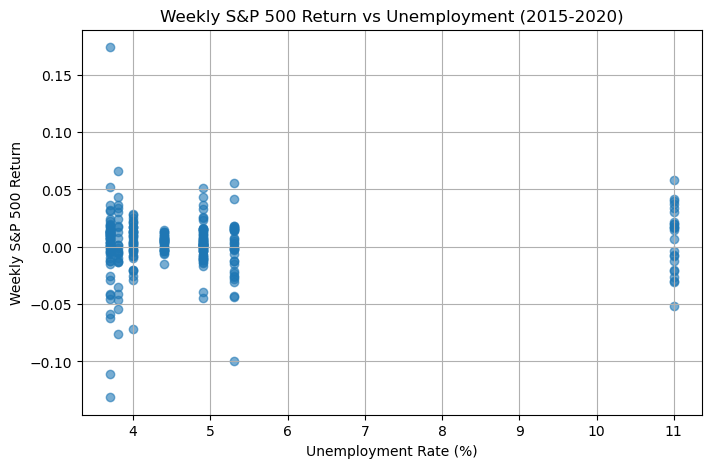

In [48]:
plt.figure(figsize=(8,5))
plt.scatter(sp500_clean['Unemployment'], sp500_clean['Return'], alpha=0.6)
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Weekly S&P 500 Return')
plt.title('Weekly S&P 500 Return vs Unemployment (2015-2020)')
plt.grid(True)
plt.show()

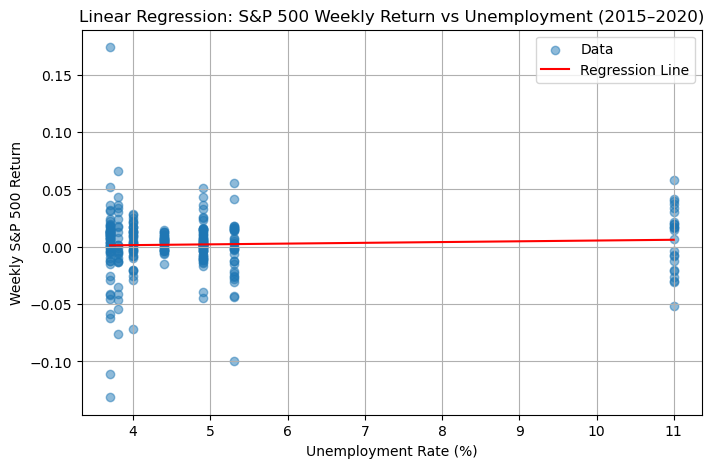

In [50]:
import numpy as np

plt.figure(figsize=(8,5))
plt.scatter(sp500_clean['Unemployment'], sp500_clean['Return'], alpha=0.5, label='Data')

# Get regression coefficients
beta0 = model.params['const']
beta1 = model.params['Unemployment']

# Generate predicted line
x_vals = np.linspace(sp500_clean['Unemployment'].min(),
                     sp500_clean['Unemployment'].max(), 100)

y_vals = beta0 + beta1 * x_vals

# Plot regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Weekly S&P 500 Return')
plt.title('Linear Regression: S&P 500 Weekly Return vs Unemployment (2015–2020)')
plt.legend()
plt.grid(True)
plt.show()